#### This is a python / R implementation for spatial analysis of radar rainfall fields.  All courtesy for the R code implementation goes to Marc Schleiss

# Notes before running:

o) make sure to have installed R properly

o) install the python library rpy2

- linux/mac users should be fine by just pip install rpy2 
- for windows, consider using anaconda and install rpy2

o) install the R libraries sp, gstat and intamap inside the R environment (best as sudo/adminstrator):

```
install.packages("sp")
install.packages("gstat")
install.packages("intamap")
```

###### To plot data in R:
```
png("myvariogram_map_24h.png",height=600,width=600)
print(plot(myisomap))
dev.off()
```

## Import python / R interface packages

In [1]:
from rpy2.robjects.packages import importr
from rpy2.robjects import r
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Inside the R environment import these geospatial packages

In [2]:
sp = importr('sp')
gstat = importr('gstat')
intamap = importr('intamap')

#### Set colors within the R environment

In [3]:
r('jet.colors  <- c("#00007F","blue","#007FFF","cyan","#7FFF7F","yellow","#FF7F00","red","#7F0000")')
r('col.palette <- colorRampPalette(jet.colors)')

R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7f4c2d1777c8 / R:0x557676b0a648>

## Read pandas coordinates of the radar grid

In [4]:
coords = pd.read_csv('./radar_xy.csv', header=None)
coords.columns = ['x', 'y']
coords.head()

,x,y
0,3649.014148,1745.990418
1,3650.003652,1745.945446
2,3651.030377,1746.036880
3,3652.020031,1745.992300
4,3653.009769,1745.947910


### Read the 24h dataset and (re)arange the pandas DataFrame

In [5]:
rainfall = pd.read_csv('./radar_sent/radar_snap_24h_2011_08_05-00_00.csv', header=None)
rainfall = pd.DataFrame(rainfall.iloc[0,5::])
rainfall.index = np.arange(0,len(rainfall),1)
rainfall.columns = ['R']
rainfall['x'] = coords['x']
rainfall['y'] = coords['y']
rainfall.head()

,R,x,y
0,3.35,3649.014148,1745.990418
1,5.65,3650.003652,1745.945446
2,5.51,3651.030377,1746.036880
3,6.24,3652.020031,1745.992300
4,7.64,3653.009769,1745.947910


### Activate the pandas to R conversion interface

In [6]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### Select only gridpoints > 0mm rain (wet mask) and assign it in the R environment

In [7]:
mask = rainfall.R>0
rainfall = rainfall[mask]

r_df = pandas2ri.py2ri(rainfall)
r.assign('mydata', r_df)

R,x,y
3.350000,3649.014148,1745.990418
5.650000,3650.003652,1745.945446
5.510000,3651.030377,1746.036880


### Transform dataset in R to geospatial dataset

In [8]:
r('''
mydata <- data.frame(mydata)
coordinates(mydata) <- ~x+y
''')

R object with classes: ('formula',) mapped to:
<RObject - Python:0x7f4c2d1729c8 / R:0x557676921198>

#### Plot map with python

In [17]:
cur_cmap = plt.cm.jet

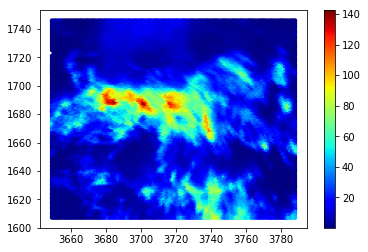

In [19]:
plt.scatter(rainfall['x'], rainfall['y'], marker='.', c=rainfall['R'], cmap=cur_cmap)
plt.colorbar()

### Bypass plot R map

In [10]:
r('''
RAD24 <- read.table("./radar_sent/radar_snap_24h_2011_08_05-00_00.csv",sep=",",colClasses="numeric")
RAD24 <- as.numeric(as.vector(RAD24))
RAD24 <- RAD24[6:length(RAD24)]
png("map_24h.png",height=900,width=900)
ncuts <- 20
cuts <- seq(min(RAD24,na.rm=TRUE),max(RAD24,na.rm=TRUE),length=ncuts)
print(spplot(mydata["R"],xlab="East [m]",ylab="North [m]",key.space="right",cuts=cuts,region=TRUE,col.regions=col.palette(ncuts),main="Rainfall [mm]",scales=list(draw=TRUE)))
dev.off()
''')

array([1], dtype=int32)

### Generate a isotropic variogram (2km separated lags, max 100km)

In [11]:
p_myiso = r('myiso <- variogram(R~1,mydata,width=2,cutoff=100)')

In [12]:
p_myiso.head()

,np,dist,gamma,dir.hor,dir.ver,id
1,97340.0,1.361011,21.909125,0.0,0.0,var1
2,342089.0,2.980286,59.871361,0.0,0.0,var1
3,599568.0,4.979613,105.459092,0.0,0.0,var1
4,781415.0,6.968800,147.173973,0.0,0.0,var1
5,1041462.0,8.972910,183.165594,0.0,0.0,var1


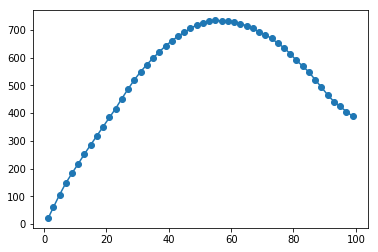

In [13]:
plt.plot(p_myiso['dist'], p_myiso['gamma'], '-o')

### Generate and save the 2D variogram map

In [14]:
p_myiso_map = r('myisomap <- variogram(R~1,mydata,width=2,cutoff=50,map=TRUE)')

r('''
png("myvariogram_map_24h.png",height=600,width=600)
print(plot(myisomap))
dev.off()
''')

array([1], dtype=int32)

### Investigate the (an)isotropy of the dataset

#### Only possible with up to 1499 values. Therefore we sort the rainfall values descendingly and assign the sorted dataset to the R environment.

In [15]:
rain_sorted = rainfall.sort_values('R', ascending=False)
rain_sorted = rain_sorted.iloc[0:1499]
rs_df = pandas2ri.py2ri(rain_sorted)
r.assign('data_sorted', rs_df)
r('''
data_sorted <- data.frame(data_sorted)
coordinates(data_sorted) <- ~x+y
''')

R object with classes: ('formula',) mapped to:
<RObject - Python:0x7f84456f00c8 / R:0x5555844db630>

#### Returns the direction of the minumum variablity clockwise from North and the anisotropy ratio

In [16]:
r('''
hat.anis <- estimateAnisotropy(data_sorted,"R")
anis <- c(90-hat.anis$direction,1/hat.anis$ratio)
''')

array([ 99.95886126,   0.78840942])

### Compute directional variograms with anisotropy direction

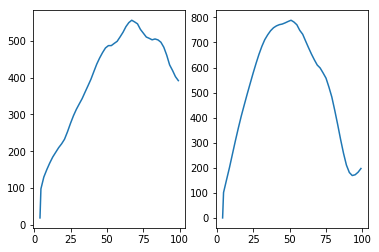

In [17]:
dir_var = r('directional_variograms <- variogram(R~1,mydata,width=2,cutoff=100,alpha=c(99.9,189.9),tol.hor=5)')

dir_1 = dir_var['dir.hor']==99.9
plt.figure()
plt.subplot(121)
plt.plot(dir_var.dist[dir_1], dir_var.gamma[dir_1])
plt.subplot(122)
plt.plot(dir_var.dist[~dir_1], dir_var.gamma[~dir_1])

### Fit initial spherical variogram to isotropic variogram

In [18]:
r('initial_vario_sph <- vgm(psill=500,model="Sph",range=40,nugget=0)')
sph_fitted = r('fitted_vario_sph <- fit.variogram(myiso,initial_vario_sph)')
print(sph_fitted)

  model       psill      range  kappa  ang1  ang2  ang3  anis1  anis2
1   Nug    0.000000   0.000000    0.0   0.0   0.0   0.0    1.0    1.0
2   Sph  669.925474  49.911368    0.5   0.0   0.0   0.0    1.0    1.0


#### Save image of fitted variogram

In [19]:
r('''
png("fitted_isotropic_variogram_sph_24h.png",height=600,width=900)
print(plot(myiso,fitted_vario_sph))
dev.off()
''')

array([1], dtype=int32)

##### fitted range

In [20]:
r('range  <- fitted_vario_sph$range[2]')

array([ 49.91136764])

##### fitted nugget

In [21]:
r('nugget <- fitted_vario_sph$psill[1]')

array([ 0.])

##### fitted sill

In [22]:
r('sill   <- sum(fitted_vario_sph$psill)')

array([ 669.9254743])

##### sum of squared errors

In [23]:
r('SSErr_sph <- attributes(fitted_vario_sph)$SSErr')

array([  2.04400622e+08])

### Fit exponential model

In [24]:
r('initial_vario_exp <- vgm(psill=500,model="Exp",range=40/3,nugget=0)')
exp_fitted = r('fitted_vario_exp <- fit.variogram(myiso,initial_vario_exp)')

##### sum of squared errors

In [25]:
r('SSErr_exp  <- attributes(fitted_vario_exp)$SSErr')

array([  4.90458050e+08])

#### Save image

In [26]:
r('''
png("fitted_isotropic_variogram_exp_24h.png",height=600,width=900)
print(plot(myiso,fitted_vario_exp))
dev.off()
''')

array([1], dtype=int32)